In [14]:
import pandas as pd
import aiosqlite
from datetime import datetime
import numpy as np
import matplotlib.pyplot as plt

In [15]:
# Путь к базе данных SQLite (из бота)
DB_NAME = 'habitat_monitoring.db'

async def get_data(class_id=None, user_id=None, start=None, finish=None, up_left=None, down_right=None):
    '''
    Возвращает pandas DataFrame с данными из SQL базы данных по заданным фильтрам.
    Параметры:
        1. class_id (list) - список идентификаторов классов для выборки.
        Если не указан или равен None, выборка производится по всем классам.
        2. user_id (int или list, optional): идентификатор пользователя или список идентификаторов.
        Если не указан или равен None, выборка производится по всем пользователям.
        3. start (str или datetime, optional): дата начала выборки (включительно).
        Если не указано, выбираются данные с самого начала.
        4. finish (str или datetime, optional): дата окончания выборки (включительно).
        Если не указано, выбираются данные до конца.
        5. up_left (tuple, optional): координаты (latitude, longitude) верхней левой точки.
        Если не указано, ограничений с этой стороны нет.
        6. down_right (tuple, optional): координаты (latitude, longitude) нижней правой точки.
        Если не указано, ограничений с этой стороны нет.
    '''
    # для отлавливания ошибок
    try:
        # Проверка параметров, переданных в функцию
        if class_id is not None and not isinstance(class_id, list):
            raise ValueError("Параметр class_id должен быть списком или None.")
        if user_id is not None and not (isinstance(user_id, (int, list))):
            raise ValueError("Параметр user_id должен быть числом, списком или None.")
        if up_left is not None:
            if (not isinstance(up_left, tuple)) or (len(up_left) != 2):
                raise ValueError("Параметр up_left должен быть кортежем из 2 элементов (latitude, longitude).")
        if down_right is not None:
            if (not isinstance(down_right, tuple)) or (len(down_right) != 2):
                raise ValueError("Параметр down_right должен быть кортежем из 2 элементов (latitude, longitude).")
        
        # Преобразование дат, если вдруг они заданы строкой
        def get_date(dt):
            if isinstance(dt, str):
                try:
                    return datetime.fromisoformat(dt)
                except ValueError:
                    raise ValueError(f"Неверный формат даты: {dt}. \nВерный формат: ГГГГ-ММ-ДД!")
            return dt
        
        if start is not None:
            start = get_date(start)
        if finish is not None:
            finish = get_date(finish)
        
        # Начинаем строить запрос
        # данные хранятся в таблице photos 
        base_query = '''SELECT 
                            timestamp AS date_time, 
                            user_id, 
                            classification_1_class AS class_id, 
                            latitude, 
                            longitude
                        FROM    
                            photos'''
        
        # список условий (WHERE) для запроса               
        conditions = []
        # список параметров для передачи в SQL
        params = []

        # Фильтр по классам
        # Формируется условие вида class_id IN (1, 2, 3) - синтаксис SQL
        if class_id:
            placeholders = ', '.join(['?'] * len(class_id))  # Преобразуем список в (?, ?, ?)
            conditions.append(f"classification_1_class IN ({placeholders})") # SQLite заменит ? значениями по порядку в списке
            params.extend(class_id)
        
        # Фильтр по user_id
        if user_id is not None:
            if isinstance(user_id, list):
                # Создаем строку с нужным количеством ?
                placeholders = ', '.join(['?'] * len(user_id))
                # Добавляем в SQL-условие конструкцию `IN (?, ?, ?)`
                conditions.append(f"user_id IN ({placeholders})")
                params.extend(user_id)
            # Если передан один user_id (число)
            else:
                # Добавляем в SQL-условие `user_id = ?`
                conditions.append("user_id = ?")
                # Добавляем в список параметров этот единственный user_id
                params.append(user_id)

        # Фильтр по дате (старт и финиш)
        # Используем DATE(timestamp), чтобы сравнивать только даты, без учета времени.
        if start is not None:
            conditions.append("DATE(timestamp) >= DATE(?)")
            params.append(start)
        if finish is not None:
            conditions.append("DATE(timestamp) <= DATE(?)")
            params.append(finish)
        
        # Фильтр по координатам
        # up_left и down_right — это координаты, задающие прямоугольник, в пределах которого нужно выбрать данные
        # up_left (верхняя левая точка) ограничивает выборку сверху и слева
        # down_right (нижняя правая точка) ограничивает выборку снизу и справа
        if up_left is not None:
            # Ограничение сверху
            conditions.append("latitude <= ?")
            # Ограничение слева
            conditions.append("longitude >= ?")
            # up_left[0] — это latitude верхней левой точки
            # up_left[1] — это долгота (longitude) верхней левой точки
            params.extend([up_left[0], up_left[1]])
        # Если задана нижняя правая точка - ограничиваем снизу по latitude и справа по longitude
        if down_right is not None:
            # Ограничение снизу
            conditions.append("latitude >= ?")
            # Ограничение справа
            conditions.append("longitude <= ?")
            params.extend([down_right[0], down_right[1]])
        
        # Собираем запрос для нашей БД
        if conditions:
            # base_query определили выше!
            # конкатенируем 2 строки - одна с базовым запром, второй с переданными условиями
            # но пока без параметров
            query = f"{base_query} WHERE " + " AND ".join(conditions)
        else:
            query = base_query

 
        
        # Асинхронное подключение к базе данных SQLite
        # Используем async with, чтобы соединение автоматически закрывалось после завершения работы

        async with aiosqlite.connect(DB_NAME) as db:
            # Выполнение SQL-запроса
            # query — строка с SQL-запросом
            # params — параметры запроса, которые передаем
            cursor = await db.execute(query, params)
            # получить данные, которые были извлечены из базы данных
            # Извлекаем все записи из результата запроса в виде списка кортежей

            rows = await cursor.fetchall()
            await cursor.close()
            
        # Создаем DataFrame из полученных данных
        # Если данных нет, возвращаем пустой DataFrame с нужными столбцами
        columns = ["date_time", "user_id", "class_id", "latitude", "longitude"]
        df = pd.DataFrame(rows, columns=columns)
        
        return df

    except Exception as e:
        print(f"Ошибка при выполнении запроса: {e}")
        return pd.DataFrame(columns=["date_time", "user_id", "class_id", "latitude", "longitude"])

Примеры запроса:

In [16]:
# Все параметры 
class_id = ['лебедь']
user_id = 123456789
start = '2024-02-03'
finish = '2025-02-03'
up_left = (55.84, 37.61)
down_right = (55.63, 38.62)
df = await get_data(class_id, user_id, start, finish, up_left, down_right)

df

,date_time,user_id,class_id,latitude,longitude
0,2024-02-25 12:00:00,123456789,лебедь,55.669205,38.083297
1,2024-02-26 12:00:00,123456789,лебедь,55.790822,38.206585
2,2024-04-12 12:00:00,123456789,лебедь,55.723283,37.634630
3,2024-04-15 12:00:00,123456789,лебедь,55.730306,37.930406
4,2024-04-18 12:00:00,123456789,лебедь,55.824797,38.105807
5,2024-04-28 12:00:00,123456789,лебедь,55.703668,38.374985
6,2024-05-04 12:00:00,123456789,лебедь,55.770357,37.886384
7,2024-05-05 12:00:00,123456789,лебедь,55.667882,38.432360
8,2024-05-06 12:00:00,123456789,лебедь,55.698765,38.260992
9,2024-06-11 12:00:00,123456789,лебедь,55.641428,37.820029


In [17]:
# Без фильров
df = await get_data()
df

,date_time,user_id,class_id,latitude,longitude
0,2025-02-06 22:47:56,0,None,NaN,NaN
1,2025-02-06 22:47:56,0,None,55.857984,37.480674
2,2025-02-06 22:47:56,0,None,55.858004,37.480702
3,2025-02-06 22:47:56,0,None,55.857984,37.480674
4,2025-02-06 22:47:56,0,None,NaN,NaN
...,...,...,...,...,...
14434,2024-12-28 12:00:00,123456789,аист,54.588554,38.476879
14435,2024-12-28 12:00:00,123456789,синица,56.870497,36.539836
14436,2024-12-28 12:00:00,123456789,синица,54.665472,38.599638
14437,2024-12-28 12:00:00,123456789,синица,56.300918,36.945605


In [18]:
# Фильтр по user_id
df = await get_data(user_id=123456789)

df

,date_time,user_id,class_id,latitude,longitude
0,2023-01-23 12:00:00,123456789,синица,55.016945,38.283749
1,2023-01-01 12:00:00,123456789,лебедь,54.140274,38.506353
2,2023-01-01 12:00:00,123456789,голубь,56.639574,37.899364
3,2023-01-01 12:00:00,123456789,аист,55.933944,36.851116
4,2023-01-01 12:00:00,123456789,аист,56.828989,38.023674
...,...,...,...,...,...
14402,2024-12-28 12:00:00,123456789,аист,54.588554,38.476879
14403,2024-12-28 12:00:00,123456789,синица,56.870497,36.539836
14404,2024-12-28 12:00:00,123456789,синица,54.665472,38.599638
14405,2024-12-28 12:00:00,123456789,синица,56.300918,36.945605


In [19]:
# Фильтр по class_id
df = await get_data(class_id=["утка","лебедь"])
df

,date_time,user_id,class_id,latitude,longitude
0,2023-01-01 12:00:00,123456789,лебедь,54.140274,38.506353
1,2023-02-01 12:00:00,123456789,лебедь,56.068717,36.933671
2,2023-02-01 12:00:00,123456789,лебедь,55.253712,36.354961
3,2023-02-01 12:00:00,123456789,лебедь,55.639547,36.845036
4,2023-02-01 12:00:00,123456789,лебедь,55.356947,36.427276
...,...,...,...,...,...
2682,2024-11-27 12:00:00,123456789,утка,54.035961,36.230689
2683,2024-11-27 12:00:00,123456789,утка,55.479130,36.406728
2684,2024-11-27 12:00:00,123456789,утка,54.403192,37.855913
2685,2024-11-28 12:00:00,123456789,утка,56.300297,36.952499


In [20]:
# Фильтр по дате
df = await get_data(start="2024-02-03", finish="2025-02-03",class_id=["утка","лебедь"])
df

,date_time,user_id,class_id,latitude,longitude
0,2024-02-03 12:00:00,123456789,лебедь,56.298807,37.864837
1,2024-02-03 12:00:00,123456789,лебедь,56.820564,38.598138
2,2024-02-04 12:00:00,123456789,лебедь,56.396331,37.600927
3,2024-02-04 12:00:00,123456789,утка,54.982597,38.851412
4,2024-02-05 12:00:00,123456789,утка,56.701096,37.709124
...,...,...,...,...,...
1279,2024-11-27 12:00:00,123456789,утка,54.035961,36.230689
1280,2024-11-27 12:00:00,123456789,утка,55.479130,36.406728
1281,2024-11-27 12:00:00,123456789,утка,54.403192,37.855913
1282,2024-11-28 12:00:00,123456789,утка,56.300297,36.952499


In [21]:
# Фильтр по координатам
# upper_left(56.08,36.5) 
# lower_right(55.38, 38.72)
df = await get_data(up_left=(56, 36.61), down_right=(55.8, 38.2))
df

,date_time,user_id,class_id,latitude,longitude
0,2025-02-06 22:47:56,0,None,55.857984,37.480674
1,2025-02-06 22:47:56,0,None,55.858004,37.480702
2,2025-02-06 22:47:56,0,None,55.857984,37.480674
3,2025-02-06 22:47:56,0,None,55.857984,37.480674
4,2025-02-06 22:47:56,0,None,55.858019,37.480666
...,...,...,...,...,...
546,2024-12-26 12:00:00,123456789,аист,55.827181,37.905997
547,2024-12-26 12:00:00,123456789,аист,55.801821,37.002870
548,2024-12-26 12:00:00,123456789,аист,55.865339,36.993123
549,2024-12-27 12:00:00,123456789,аист,55.973324,36.649593


In [31]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.spatial import ConvexHull 

def is_inside_polygon(x, y, vertices):
    """ Проверяет, находится ли точка (x, y) внутри многоугольника. """
    n = len(vertices)
    inside = False
    p1x, p1y = vertices[0]
    for i in range(n + 1):
        p2x, p2y = vertices[i % n]
        if y > min(p1y, p2y):
            if y <= max(p1y, p2y):
                if x <= max(p1x, p2x):
                    if p1y != p2y:
                        xints = (y - p1y) * (p2x - p1x) / (p2y - p1y) + p1x
                    if p1x == p2x or x <= xints:
                        inside = not inside
        p1x, p1y = p2x, p2y
    return inside

def calculate_real_area(vertices, df_points):
    """ Рассчитывает площадь ареала на основе реальных данных. """
    if df_points.empty:
        return 0.0
    
    # Находим минимальные и максимальные значения координат вершин
    min_x = min(v[0] for v in vertices)
    max_x = max(v[0] for v in vertices)
    min_y = min(v[1] for v in vertices)
    max_y = max(v[1] for v in vertices)
    
    # Вычисляем площадь прямоугольника, охватывающего ареал
    rect_area = (max_x - min_x) * (max_y - min_y)
    
    # Фильтруем точки, которые попадают в прямоугольник
    df_filtered = df_points[
        (df_points['longitude'] >= min_x) &
        (df_points['longitude'] <= max_x) &
        (df_points['latitude'] >= min_y) &
        (df_points['latitude'] <= max_y)
    ]
    
    # Подсчитываем общее количество точек в прямоугольнике
    total_points = len(df_filtered)
    if total_points == 0:
        return 0.0
    
    # Подсчитываем количество точек, которые находятся внутри ареала
    inside_count = sum(is_inside_polygon(row['longitude'], row['latitude'], vertices) 
                       for _, row in df_filtered.iterrows())
    
    # Оцениваем площадь ареала на основе доли точек внутри него
    return (inside_count / total_points) * rect_area

def calculate_convex_hull(df_points, class_id=None):
    """
    Рассчитывает выпуклую оболочку для точек данных.
    Если указан class_id, фильтрует данные по классу.
    Возвращает вершины выпуклой оболочки.
    """
    # Фильтруем данные по классу, если class_id указан
    if class_id is not None:
        df_filtered = df_points[df_points['class_id'] == class_id]
    else:
        df_filtered = df_points
    
    # Извлекаем координаты точек
    points = df_filtered[['longitude', 'latitude']].values
    
    # Если точек меньше 3, выпуклая оболочка не может быть построена
    if len(points) < 3:
        raise ValueError("Для построения выпуклой оболочки нужно как минимум 3 точки.")
    
    # Рассчитываем выпуклую оболочку
    hull = ConvexHull(points)
    
    # Возвращаем вершины выпуклой оболочки
    return points[hull.vertices]

def visualize_real_data(vertices, df_points, class_id=None):
    """ Визуализирует точки и ареал с информацией о площади. """
    plt.figure(figsize=(10, 6))
    # Закрашиваем область ареала
    plt.fill(*zip(*vertices), alpha=0.3, label='Ареал обитания')
    
    # Фильтруем данные по классу, если class_id указан
    if class_id is not None:
        df_points = df_points[df_points['class_id'] == class_id]
    
    # Определяем, какие точки находятся внутри ареала
    inside = df_points.apply(lambda row: is_inside_polygon(row['longitude'], row['latitude'], vertices), axis=1)
    df_in = df_points[inside]
    df_out = df_points[~inside]
    
    # Отображаем точки внутри ареала зелёным цветом
    plt.scatter(df_in['longitude'], df_in['latitude'], c='green', alpha=0.6)
    # Отображаем точки вне ареала красным цветом
    plt.scatter(df_out['longitude'], df_out['latitude'], c='red', alpha=0.6)
    # Рисуем границы ареала синей пунктирной линией
    plt.plot(*zip(*vertices, vertices[0]), 'b--', label='Границы ареала')
    
    # Рассчитываем площадь ареала
    area = calculate_real_area(vertices, df_points)
    
    # Добавляем информацию о площади на график
    plt.text(
        0.5, 0.95,  # Позиция текста (относительно осей)
        f'Оценочная площадь ареала обитания: {area:.2f}',  # Текст
        transform=plt.gca().transAxes,  # Используем оси графика
        fontsize=12,
        ha='center',  # Выравнивание по центру
        bbox=dict(facecolor='white', alpha=0.8)  # Фон текста
    )
    
    # Подписываем оси и добавляем заголовок
    plt.xlabel('Долгота')
    plt.ylabel('Широта')
    plt.title(f'Распределение наблюдений для класса: {class_id}' if class_id else 'Распределение наблюдений')
    # Добавляем легенду
    plt.legend()
    # Включаем сетку
    plt.grid(True)
    # Отображаем график
    plt.show()

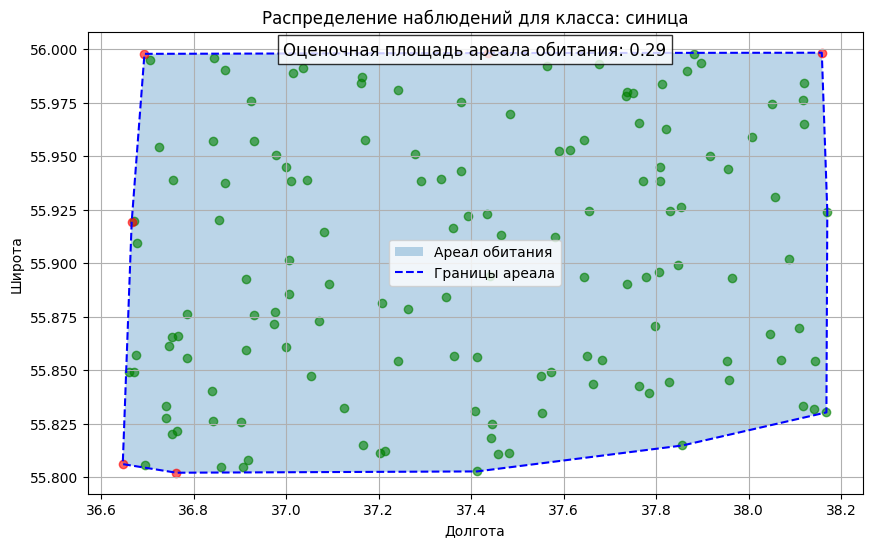

In [32]:
# Пример использования
class_id = 'синица'  
vertices = calculate_convex_hull(df, class_id=class_id)  # Рассчитываем ареал для выбранного класса
visualize_real_data(vertices, df, class_id=class_id)  # Визуализируем данные для выбранного класса